# Physiology Lab - Fall 2019
# Oxygen Equilibrium of Hemocyanin Report

For this report, Dr. Beers only wants three graphs generated from the data obtained during lab. 

1. Plot % Oxygen Saturation (y-axis) as a funciton of oxygen partial pressure (x-axis). Determine the P<sub>50</sub> of the pigment under the experimental conditions.

In [21]:
hemodat = read.csv('OxygenEqHemo.csv')
hemodat$pH = as.factor(hemodat$pH)

In [22]:
hemodat$hill = log((hemodat$Percent.Oxy.Sat)*100/(100-(hemodat$Percent.Oxy.Sat*100)))
head(hemodat)

pH,Volume.O2.Added..mL.,Absorbance,Barometric.Pressure..Torr.,Vapor.Pressure..Torr.,Volume.of.Tonometer..mL.,PO2,Percent.Oxy.Sat,hill
<fct>,<int>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
7.3,0,0.007,764.25,24.195,610,0.000000,NA,NA
7.3,5,0.017,764.25,24.195,610,6.066025,0.03717472,-3.2542430
7.3,15,0.027,764.25,24.195,610,18.198074,0.07434944,-2.5217206
7.3,35,0.070,764.25,24.195,610,42.462172,0.23420074,-1.1847414
7.3,55,0.153,764.25,24.195,610,66.726270,0.54275093,0.1714223
7.3,65,0.194,764.25,24.195,610,78.858320,0.69516729,0.8243894


In [23]:
hem_73 = hemodat[hemodat$pH == '7.3',]
hem_68 = hemodat[hemodat$pH == '6.8',]
hem_78 = hemodat[hemodat$pH == '7.8',]

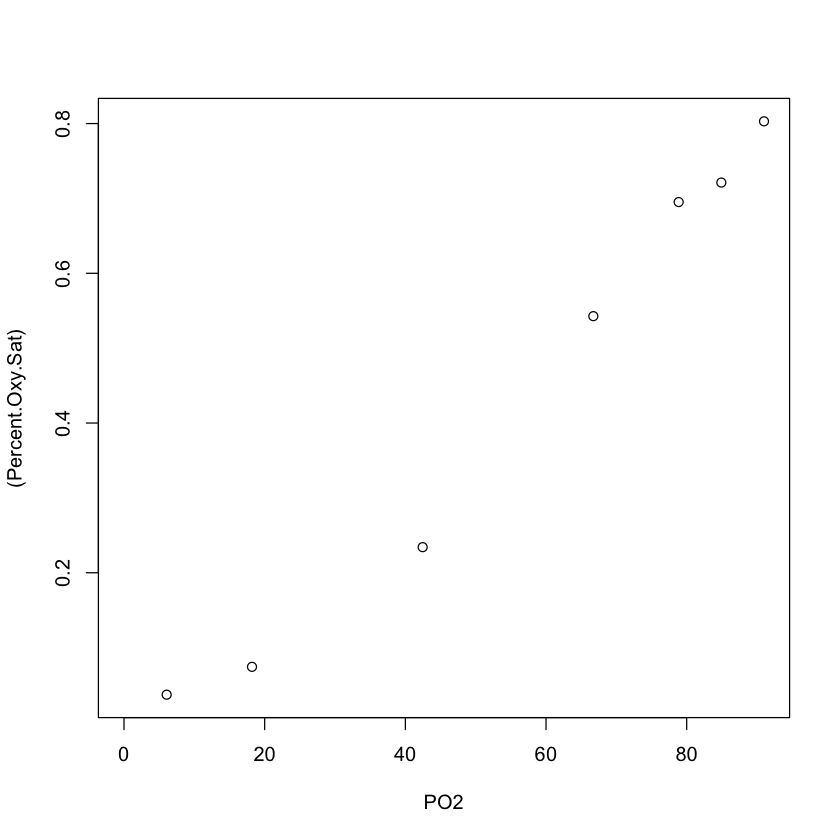

In [24]:
plot((Percent.Oxy.Sat)~(PO2), data=hem_73)

In [25]:
require(sicegar)

In [26]:
# Lets abuse this package
time = hem_73$PO2
intensity = hem_73$Percent.Oxy.Sat
di = data.frame(time, intensity)

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


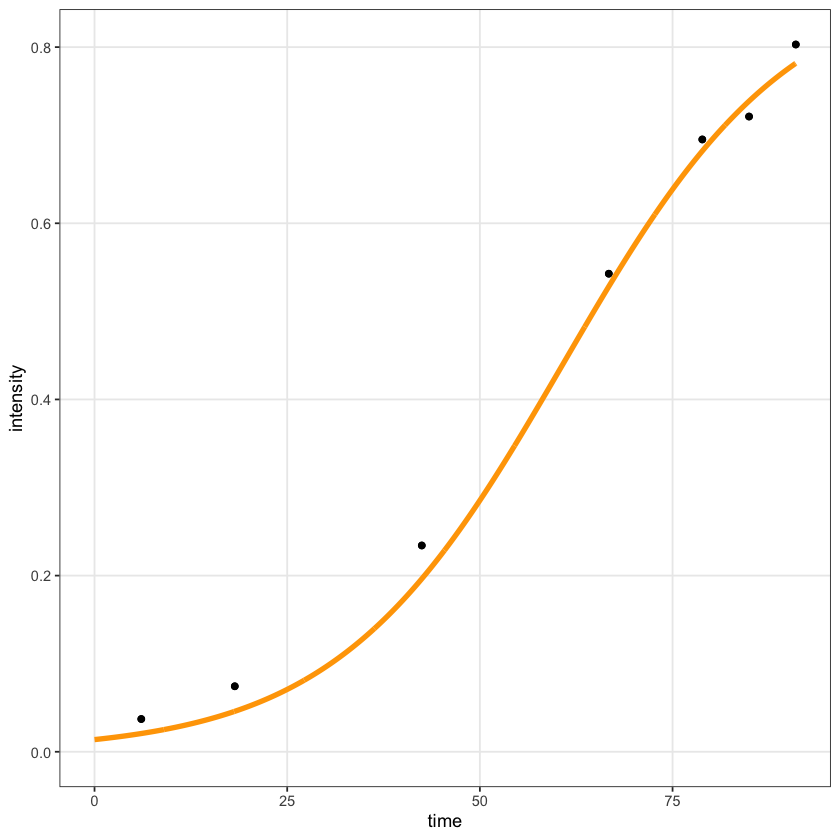

In [27]:
# This function will only take a data frame with columns named time 
# and intensity, but we want to abuse it
fitObj_di = fitAndCategorize(dataInput = di)
figureModelCurves(dataInput = fitObj_di$normalizedInput, sigmoidalFitVector = fitObj_di$sigmoidalModel)

Ok, that graph above is cool and all, but the axis titles are wrong and we need to be able to draw lines on this... So, of course, we turn to GitHub so we can hijack this function to do our own bidding...


In [28]:
#' @title Generate model associated figures.
#'
#' @param dataInput A data frame or a list contatining the dataframe. The data frame should be composed of at least two columns. One represents time, and the other represents intensity. The data should be normalized with the normalize data function sicegar::normalizeData() before imported into this function.
#' @param sigmoidalFitVector the output of the sicegar::sigmoidalFitFunction(), or the agumented version of the output generated by the help of sicegar::parameterCalculation(), which contains parameters related with sigmoidal model. Default is NULL.
#' @param doubleSigmoidalFitVector the output of the sicegar::doubleSigmoidalFitFunction(), or the agumented version of the output generated by the help of sicegar::parameterCalculation(), which contains parameters related with double sigmoidal model. Default is NULL.
#' @param showParameterRelatedLines if equal to TRUE, figure will show parameter related lines on the curves. Default is FALSE.
#' @param xlabelText the x-axis name; with default "time"
#' @param ylabelText the y-axis name; with default "intensity"
#' @param fittedXmin the minimum of the fitted data that will be plotted (Default 0)
#' @param fittedXmax the maximum of the fitted data that will be plotted (Default timeRange)
#'
#' @description Generates figures using ggplot that shows the input data and the fitted curves.
#' @return Returns infection curve figures.
#' @export
#'
#' @examples
#'time <- seq(3, 24, 0.1)
#'
#'#simulate intensity data and add noise
#'noise_parameter <- 0.2
#'intensity_noise <- runif(n = length(time), min = 0, max = 1) * noise_parameter
#'intensity <- sicegar::doublesigmoidalFitFormula(time,
#'                                                finalAsymptoteIntensityRatio = .3,
#'                                                maximum = 4,
#'                                                slope1Param = 1,
#'                                                midPoint1Param = 7,
#'                                                slope2Param = 1,
#'                                                midPointDistanceParam = 8)
#'intensity <- intensity + intensity_noise
#'
#'dataInput <- data.frame(intensity = intensity, time = time)
#'normalizedInput <- sicegar::normalizeData(dataInput, dataInputName = "sample001")
#'
#'
#'# Do the double sigmoidal fit
#'doubleSigmoidalModel <- sicegar::multipleFitFunction(dataInput = normalizedInput,
#'                                                     model = "doublesigmoidal",
#'                                                     n_runs_min = 20,
#'                                                     n_runs_max = 500,
#'                                                     showDetails = FALSE)
#'
#'doubleSigmoidalModel <- sicegar::parameterCalculation(doubleSigmoidalModel)
#'
#'fig01 <- sicegar::figureModelCurves(dataInput = normalizedInput,
#'                                   doubleSigmoidalFitVector = doubleSigmoidalModel,
#'                                   showParameterRelatedLines = TRUE)
#'print(fig01)
#'
#'
moddedfigureModelCurves <- function(dataInput,
                              sigmoidalFitVector = NULL,
                              doubleSigmoidalFitVector = NULL,
                              showParameterRelatedLines = FALSE,
                              xlabelText = "PO2 (torr)", ylabelText = "Percent Saturation",
                              fittedXmin = 0, fittedXmax = NA){

  # get data from data input
  dataOutputVariable <- dataCheck(dataInput) # check if the data structure is correct
  sameSourceDataCheck(dataInput,
                      sigmoidalFitVector,
                      doubleSigmoidalFitVector) # check if all data comes from same source

  # get data from data structure
  isalist <- (is.list(dataInput) & !is.data.frame(dataInput))
  if (isalist){
    dataInput <- unnormalizeData(dataInput)
    dataFrameInput <- dataInput$timeIntensityData
  }
  isadataframe = (is.data.frame(dataInput))
  if (isadataframe){
    dataFrameInput <- dataInput
  }



  # SIGMOIDAL
  if (!is.null(sigmoidalFitVector)){
    if (!sigmoidalFitVector$model == "sigmoidal"){
      stop("provided sigmoidalFitVector is not a sigmoidal fit vector")
    }
    if (!sigmoidalFitVector$isThisaFit){
      warning("provided sigmoidal fit vector does not include a fit!")
    }
    if (sigmoidalFitVector$isThisaFit){
      # Extract Parameters from the sigmoidalFitVector
      maximum_x <- sigmoidalFitVector$maximum_x
      maximum_y <- sigmoidalFitVector$maximum_y
      midPoint_x <- sigmoidalFitVector$midPoint_x
      midPoint_y <- sigmoidalFitVector$midPoint_y
      slope <- sigmoidalFitVector$slope
      slopeParam <- sigmoidalFitVector$slopeParam_Estimate
      incrementTime <- sigmoidalFitVector$incrementTime
      startPoint_x <- sigmoidalFitVector$startPoint_x
      startPoint_y <- sigmoidalFitVector$startPoint_y
      reachMaximum_x <- sigmoidalFitVector$reachMaximum_x
      reachMaximum_y <- sigmoidalFitVector$reachMaximum_y

      # Generate the Time Series for Fitted Data
      if (is.na(fittedXmax)){
        fittedXmax_sigmoidal <- sigmoidalFitVector$dataScalingParameters.timeRange
      }
      if (!is.na(fittedXmax)){
        fittedXmax_sigmoidal <- fittedXmax
      }
      if (fittedXmin == 0){
        fittedXmin_sigmoidal <- 0
      }
      if (fittedXmin != 0){
        fittedXmin_sigmoidal <- fittedXmin
      }

      time <- seq(fittedXmin_sigmoidal,
                  fittedXmax_sigmoidal,
                  fittedXmax_sigmoidal / 1000)

      intensityTheoreticalSigmoidal <- sicegar::sigmoidalFitFormula(time,
                                                                    maximum = maximum_y,
                                                                    slopeParam = slopeParam,
                                                                    midPoint = midPoint_x)
      intensityTheoreticalSigmoidalDf <- data.frame(time, intensityTheoreticalSigmoidal)
    }
  }



  # DOUBLE SIGMOIDAL
  if (!is.null(doubleSigmoidalFitVector))
  {
    if(!doubleSigmoidalFitVector$model=="doublesigmoidal"){
      stop("provided doubleSigmoidalFitVector is not a double sigmoidal fit vector")
    }
    if(!doubleSigmoidalFitVector$isThisaFit){
      warning("provided double sigmoidal fit vector does not include a fit!")
    }
    if(doubleSigmoidalFitVector$isThisaFit){
      # Extract Parameters from the sigmoidalFitVector
      maximum_x <- doubleSigmoidalFitVector$maximum_x
      maximum_y <- doubleSigmoidalFitVector$maximum_y

      midPoint1_x <- doubleSigmoidalFitVector$midPoint1_x
      midPoint1_y <- doubleSigmoidalFitVector$midPoint1_y
      midPoint1Param <- doubleSigmoidalFitVector$midPoint1Param_Estimate
      midPoint2_x <- doubleSigmoidalFitVector$midPoint2_x
      midPoint2_y <- doubleSigmoidalFitVector$midPoint2_y
      midPointDistanceParam <- doubleSigmoidalFitVector$midPointDistanceParam_Estimate

      slope1 <- doubleSigmoidalFitVector$slope1
      slope1Param <- doubleSigmoidalFitVector$slope1Param_Estimate
      slope2 <- doubleSigmoidalFitVector$slope2
      slope2Param <- doubleSigmoidalFitVector$slope2Param_Estimate

      finalAsymptoteIntensity <- doubleSigmoidalFitVector$finalAsymptoteIntensity
      finalAsymptoteIntensityRatio <- doubleSigmoidalFitVector$finalAsymptoteIntensityRatio_Estimate

      incrementTime <- doubleSigmoidalFitVector$incrementTime
      startPoint_x <- doubleSigmoidalFitVector$startPoint_x
      startPoint_y <- doubleSigmoidalFitVector$startPoint_y
      reachMaximum_x <- doubleSigmoidalFitVector$reachMaximum_x
      reachMaximum_y <- doubleSigmoidalFitVector$reachMaximum_y

      decrementTime <- doubleSigmoidalFitVector$decrementTime
      startDeclinePoint_x <- doubleSigmoidalFitVector$startDeclinePoint_x
      startDeclinePoint_y <- doubleSigmoidalFitVector$startDeclinePoint_y
      endDeclinePoint_x <- doubleSigmoidalFitVector$endDeclinePoint_x
      endDeclinePoint_y <- doubleSigmoidalFitVector$endDeclinePoint_y

      # Generate the Time Series for Fitted Data
      if(is.na(fittedXmax)){
        fittedXmax_doublesigmoidal <- doubleSigmoidalFitVector$dataScalingParameters.timeRange
      }
      if(!is.na(fittedXmax)){
        fittedXmax_doublesigmoidal = fittedXmax
      }

      if(fittedXmin == 0){
        fittedXmin_doublesigmoidal <- 0
      }
      if(fittedXmin != 0)
      {fittedXmin_doublesigmoidal <- fittedXmin}

      time <- seq(fittedXmin_doublesigmoidal,
                  fittedXmax_doublesigmoidal,
                  fittedXmax_doublesigmoidal / 1000)

      intensityTheoreticalDoubleSigmoidal <- doublesigmoidalFitFormula(time,
                                                                       finalAsymptoteIntensityRatio = finalAsymptoteIntensityRatio,
                                                                       maximum = maximum_y,
                                                                       slope1Param = slope1Param,
                                                                       midPoint1Param = midPoint1Param,
                                                                       slope2Param = slope2Param,
                                                                       midPointDistanceParam = midPointDistanceParam)
      intensityTheoreticalDoubleSigmoidalDf <- data.frame(time,intensityTheoreticalDoubleSigmoidal)
    }
  }

  output <- ggplot2::ggplot(dataFrameInput) +
    ggplot2::geom_point(ggplot2::aes_(x=~time, y=~intensity)) +
    ggplot2::expand_limits(x = 0, y = 0) +
    ggplot2::theme_bw() +
    ggplot2::theme(panel.grid.minor = ggplot2::element_blank()) +
    ggplot2::xlab(xlabelText) + ggplot2::ylab(ylabelText)

  if(!is.null(sigmoidalFitVector)){

    if(sigmoidalFitVector$isThisaFit){

      if(showParameterRelatedLines){

        if(!sigmoidalFitVector$additionalParameters){
          stop("to show parameter related lines one needs to run sicegar::parameterCalculation for sigmoidalModel ")
        }
        if(sigmoidalFitVector$additionalParameters){

          # Lines related with the sigmoidal fit line
          output <- output +
            ggplot2::geom_hline(yintercept = 0, colour = "#bdbdbd", size = 0.5, linetype = "longdash") +
            ggplot2::geom_hline(yintercept = maximum_y,
                                colour = "#bdbdbd", size = 0.5, linetype = "longdash") +
            ggplot2::geom_segment(x = startPoint_x,
                                  y = startPoint_y,
                                  xend = reachMaximum_x,
                                  yend = reachMaximum_y,
                                  colour = "#bdbdbd", size = 0.5, linetype = "longdash")
        }
      }

      output <- output +
        ggplot2::geom_point(data = dataFrameInput, ggplot2::aes_(x = ~time, y = ~intensity)) +
        ggplot2::geom_line(data = intensityTheoreticalSigmoidalDf,
                           ggplot2::aes_(x = ~time, y = ~intensityTheoreticalSigmoidal), color = "orange", size = 1.5)

      if(showParameterRelatedLines){

        if(sigmoidalFitVector$additionalParameters){

          # Points related with the sigmoidal fit line
          output <- output +
            ggplot2::geom_point(x = midPoint_x,
                                y = midPoint_y,
                                colour = "red", size = 6, shape = 13)
        }
      }
    }
  }

  if(!is.null(doubleSigmoidalFitVector)){

    if(doubleSigmoidalFitVector$isThisaFit){

      if(showParameterRelatedLines){

        if(!doubleSigmoidalFitVector$additionalParameters ){
          stop("to show parameter related lines one needs to run sicegar::parameterCalculation for doubleSigmoidalModel ")
        }

        if(doubleSigmoidalFitVector$additionalParameters){

          # Lines related with the double sigmoidal fit line (with numerical correction)
          output <- output +
            ggplot2::geom_hline(yintercept = 0, colour = "#bdbdbd", size = 0.5, linetype = "longdash") +
            ggplot2::geom_hline(yintercept = maximum_y,
                                colour = "#bdbdbd", size = 0.5, linetype = "longdash") +
            ggplot2::geom_segment(x = maximum_x,
                                  y = finalAsymptoteIntensity,
                                  xend = Inf,
                                  yend = finalAsymptoteIntensity,
                                  colour = "#bdbdbd", size = 0.5, linetype = "longdash") +
            ggplot2::geom_segment(x = startPoint_x,
                                  y = startPoint_y,
                                  xend = reachMaximum_x,
                                  yend = reachMaximum_y,
                                  colour = "#bdbdbd", size = 0.5, linetype = "longdash") +
            ggplot2::geom_segment(x = startDeclinePoint_x,
                                  y = startDeclinePoint_y,
                                  xend = endDeclinePoint_x,
                                  yend = endDeclinePoint_y,
                                  colour = "#bdbdbd", size = 0.5, linetype = "longdash")
        }
      }

      output <- output +
        ggplot2::geom_point(data = dataFrameInput, ggplot2::aes_(x = ~time, y = ~intensity)) +
        ggplot2::geom_line(data = intensityTheoreticalDoubleSigmoidalDf,
                           ggplot2::aes_(x = ~time, y = ~intensityTheoreticalDoubleSigmoidal), color = "orange", size = 1.5)

      if(showParameterRelatedLines){

        if(doubleSigmoidalFitVector$additionalParameters){

          # Points related with the double sigmoidal fit line (with numerical correction)
          output <- output +
            ggplot2::geom_point(x = maximum_x, y = maximum_y,
                                colour = "red", size = 6, shape = 13) +
            ggplot2::geom_point(x = midPoint1_x, y = midPoint1_y,
                                colour = "red", size = 6, shape = 13) +
            ggplot2::geom_point(x = midPoint2_x, y = midPoint2_y,
                                colour = "red", size = 6, shape = 13)

        }
      }
    }
  }

  # data should contain same source


  return(output)
}

#' @title Check is data came from the same source.
#'
#' @param dataInput a data frame composed of two columns. One is for time and the other is for intensity. Should be normalized data generated by normalizeData.
#' @param sigmoidalFitVector is the output of sigmoidalFitFunction. Default is NULL.
#' @param doubleSigmoidalFitVector is the output of double sigmoidal fit function. Default is NULL.
#'
#' @description Checks if the provided data and models came from same source by looking to ".dataInputName" columns of the inputs.
#' @return Returns TRUE if models can from same source, FALSE otherwise.
#' @export
#'
sameSourceDataCheck <- function(dataInput,
                                sigmoidalFitVector,
                                doubleSigmoidalFitVector){

  # do the checks for data input
  # decide if data input is a data frame or a normalized data frame
  isalist <- (is.list(dataInput) & !is.data.frame(dataInput))
  if(isalist){
    sameSourceDataCheck.dataInput=dataInput$dataInputName
  }
  isadataframe <- (is.data.frame(dataInput))
  if(isadataframe){
    sameSourceDataCheck.dataInput <- NA
  }


  # do the checks for sigmoidal fit vector
  # decide if sigmoidal fit is provided or not
  if(is.null(sigmoidalFitVector)){
    sameSourceDataCheck.sigmoidal <- NA
  }
  if(!is.null(sigmoidalFitVector)){
    sameSourceDataCheck.sigmoidal <- sigmoidalFitVector$dataInputName
  }

  # do the checks for double sigmoidal fit vector
  # decide if double sigmoidal fit is provided or not
  if(is.null(doubleSigmoidalFitVector)){
    sameSourceDataCheck.doublesigmoidal <- NA
  }
  if(!is.null(doubleSigmoidalFitVector)){
    sameSourceDataCheck.doublesigmoidal <- doubleSigmoidalFitVector$dataInputName
  }

  # make decision
  sameSourceDataCheckVector <- c(dataInput = sameSourceDataCheck.dataInput,
                                 sigmoidal = sameSourceDataCheck.sigmoidal,
                                 doublesigmoidal = sameSourceDataCheck.doublesigmoidal)
  sameSourceDataCheckVector <- sameSourceDataCheckVector[!is.na(sameSourceDataCheckVector)]

  if(length(sameSourceDataCheckVector) != 0){
    if(!all(sameSourceDataCheckVector[1] == sameSourceDataCheckVector)){
      print(sameSourceDataCheckVector)
      stop("all data need to come from same source!")
    }
  }
}


Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


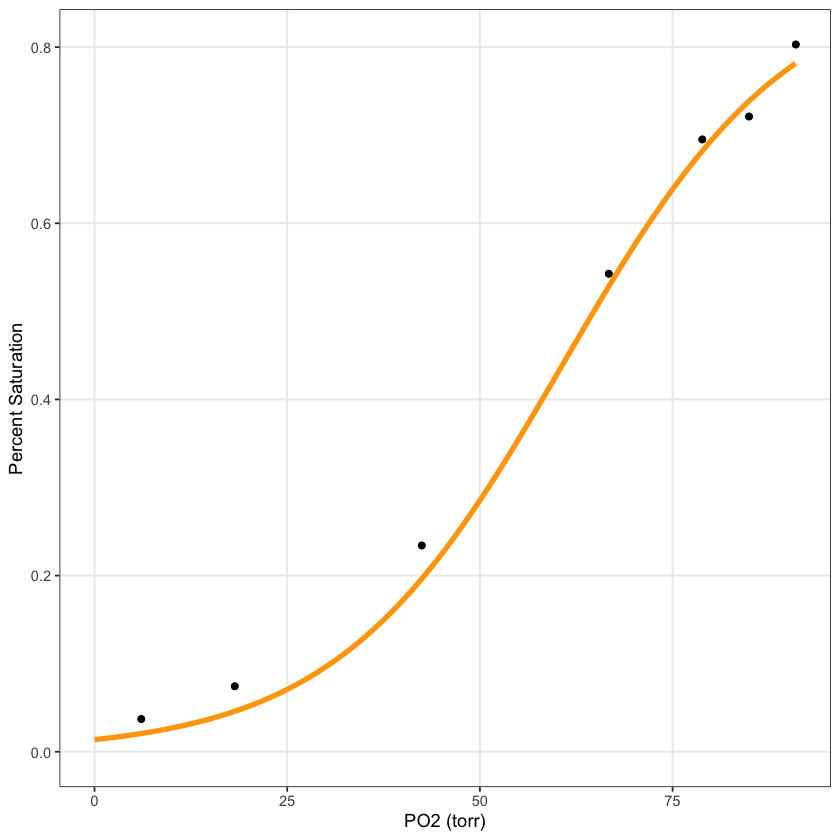

In [19]:
moddedfigureModelCurves(dataInput = fitObj_di$normalizedInput, sigmoidalFitVector = fitObj_di$sigmoidalModel)

2. Estimate the cooperativity of the hemocyanin (i.e. Create a Hill Plot). An estimate of cooperativity between hemocyanin subunits can bbe obtained by plotting the log of percent saturation ove rpercent unsaturation as a function of the log of Po<sub>2</sub> and measuring the slope of the line around P<sub>50</sub> (n or sometimes n<sub>50</sub>). This number is an indec of cooperativity. The higher the number, the grater the cooperativity.


Call:
lm(formula = hill ~ log(PO2), data = hem_73)

Residuals:
      2       3       4       5       6       7       8 
 0.5685 -0.6034 -0.7352 -0.1625  0.2009  0.1984  0.5334 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -6.9476     0.8784  -7.909 0.000520 ***
log(PO2)      1.7335     0.2295   7.552 0.000645 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5689 on 5 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.9194,	Adjusted R-squared:  0.9033 
F-statistic: 57.03 on 1 and 5 DF,  p-value: 0.0006453


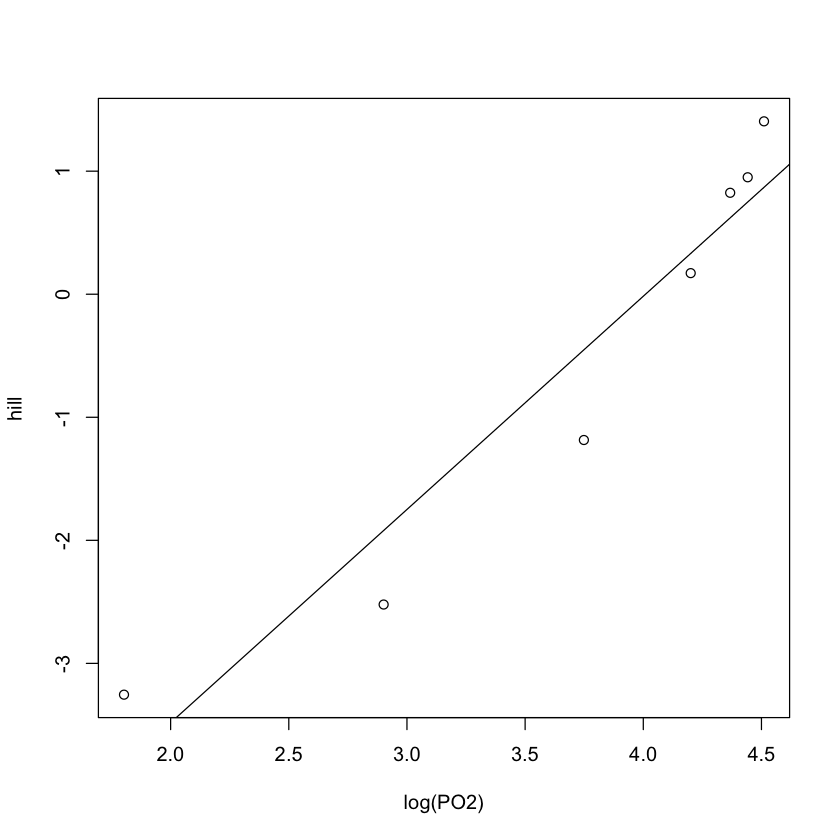

In [32]:
summary(lm(hill~log(PO2), data=hem_73))
plot(hill~log(PO2), data=hem_73)
abline(a = -6.948, b = 1.733)

3. Create a magnitude of Bohr Shift graph.